In [760]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import uncertainties as u
import re

In [761]:
# Measurement Information

N_MEASUREMENTS = 100
N_POINTS = 100000

In [762]:
# Obtain Files
# For 6/12 data, channel 1 shows spectrum and channel 2 shows calibration

Directory = r"/users/laratatli/PycharmProjects/laser-spec/data_6_12/"

In [763]:
# Obtain spectrum scale values

with open(Directory + "ch1_paramiters.txt", "r") as file:
    lines = file.readlines()
    
scale_factors_spectrum = {key: [] for key in ["XZERO", "XINCR", "YZERO", "YMULT"] }

for line in lines:
    for key in scale_factors_spectrum:
        match = re.search(rf"{key} ([\dE.+-]+)", line)
        if match:
            scale_factors_spectrum[key].append(float(match.group(1)))

#print("Scaling factors:", scale_factors_spectrum) # use this to check scale factors are consistent across all runs

for key in scale_factors_spectrum:
    print(key, scale_factors_spectrum[key][0]) # return scale factors assuming the check above passes

XZERO -0.093
XINCR 2e-06
YZERO -0.046
YMULT 0.0004


In [764]:
# Obtain calibration scale values

with open(Directory + "ch2_paramiters.txt", "r") as file:
    lines = file.readlines()
    
scale_factors_calibration = {key: [] for key in ["XZERO", "XINCR", "YZERO", "YMULT"] }

for line in lines:
    for key in scale_factors_calibration:
        match = re.search(rf"{key} ([\dE.+-]+)", line)
        if match:
            scale_factors_calibration[key].append(float(match.group(1)))

#print("Scaling factors:", scale_factors_calibration) # use this to check scale factors are consistent across all runs

for key in scale_factors_calibration:
    print(key, scale_factors_calibration[key][0]) # return scale factors assuming the check above passes

XZERO -0.093
XINCR 2e-06
YZERO 0.01956
YMULT 4e-05


In [765]:
# Assign scale factor variables

SPECTRUM_XZERO= scale_factors_spectrum["XZERO"][0]
SPECTRUM_XINCR= scale_factors_spectrum["XINCR"][0]
SPECTRUM_YZERO= scale_factors_spectrum["YZERO"][0]
SPECTRUM_YMULT= scale_factors_spectrum["YMULT"][0]

CALIBRATION_XZERO= scale_factors_calibration["XZERO"][0]
CALIBRATION_XINCR= scale_factors_calibration["XINCR"][0]
CALIBRATION_YZERO= scale_factors_calibration["YZERO"][0]
CALIBRATION_YMULT= scale_factors_calibration["YMULT"][0]

In [766]:
# Calculate the mean and standard deviations of both data sets

#calculating means
mean_spectrum_unscaled = np.zeros(N_POINTS)
mean_calibration_unscaled = np.zeros(N_POINTS)

#sum values
for i in range(N_MEASUREMENTS):
    mean_spectrum_unscaled += np.fromfile(Directory+"ch1_{}.bin".format(i), dtype='int8')
    mean_calibration_unscaled += np.fromfile(Directory+"ch2_{}.bin".format(i), dtype='int8')

#divide by number of values to obtain mean
mean_spectrum_unscaled = mean_spectrum_unscaled/N_MEASUREMENTS
mean_calibration_unscaled = mean_calibration_unscaled/N_MEASUREMENTS

std_spectrum_unscaled = np.zeros(N_POINTS)
std_calibration_unscaled = np.zeros(N_POINTS)


#sum deviations squared
for i in range(N_MEASUREMENTS):
    std_spectrum_unscaled += (np.fromfile(Directory+"ch1_{}.bin".format(i),dtype='int8')-mean_spectrum_unscaled)**2
    std_calibration_unscaled += (np.fromfile(Directory+"ch1_{}.bin".format(i),dtype='int8')-mean_calibration_unscaled)**2

#divide by the degrees of freedom - obtains variance
std_spectrum_unscaled = np.sqrt(std_spectrum_unscaled/(N_MEASUREMENTS-1))
std_calibration_unscaled = np.sqrt(std_calibration_unscaled/(N_MEASUREMENTS-1))

In [767]:
#generate unscaled time data - we need to do this as oscilloscope itself doesn't

spectrum_time_unscaled = np.arange(0, N_POINTS)
calibration_time_unscaled = np.arange(0, N_POINTS)

In [768]:
#scaling data (check programmer handbook for guide on this, essentially it's a linear transformation)

mean_spectrum = (SPECTRUM_YMULT * mean_spectrum_unscaled) + SPECTRUM_YZERO

mean_calibration = (CALIBRATION_YMULT * mean_calibration_unscaled) + CALIBRATION_YZERO

spectrum_time = (SPECTRUM_XINCR * spectrum_time_unscaled) + SPECTRUM_XZERO

calibration_time = (CALIBRATION_XINCR * calibration_time_unscaled) + CALIBRATION_XZERO

std_spectrum = (SPECTRUM_YMULT*std_spectrum_unscaled) + SPECTRUM_YZERO

std_calibration = (CALIBRATION_YMULT*std_calibration_unscaled) + CALIBRATION_YZERO

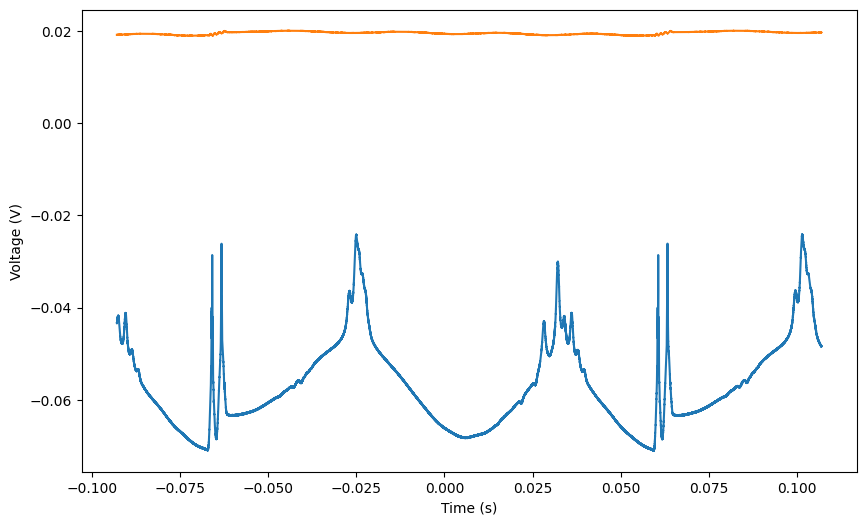

In [769]:
# Testing figures

plt.figure(figsize=(10,6))
plt.plot(spectrum_time, mean_spectrum)
plt.plot(calibration_time, mean_calibration)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()

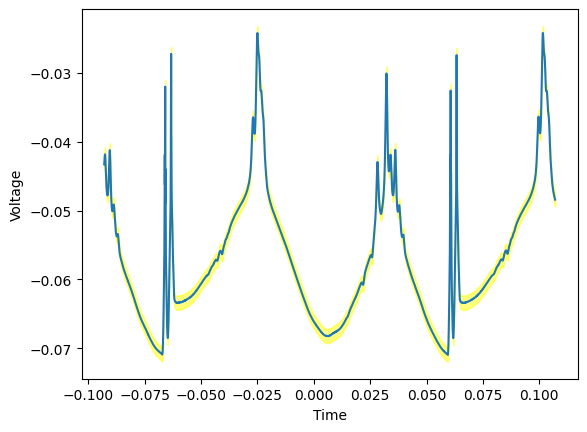

In [770]:
# TIME-AVERAGING THE SPECTRUM DATA

#work out averages by grouping

N_GROUPS = 5000
group_step = N_POINTS//N_GROUPS # calculating group sizes

if N_POINTS % N_GROUPS != 0:
    print("Warning: data points do not divide evenly into groups.")

mean_spectrum_time = np.zeros(N_GROUPS)
weighted_mean_spectrum = np.zeros(N_GROUPS)
err_mean_spectrum = np.zeros(N_GROUPS)

# weighted mean calculations: page 66 hughes & hase
w = 1 / (std_spectrum / np.sqrt(N_MEASUREMENTS - 1))**2
x = mean_spectrum

if np.any(std_spectrum == 0):
    raise ValueError("Standard deviation contains zero values, which would cause division by zero.")

for i in range(N_GROUPS):
    # start_idx = i * group_step
    # end_idx = min((i + 1) * group_step, N_POINTS)
    # mean_spectrum_time[i] = np.mean(spectrum_time[start_idx:end_idx]) # calculates average of spectrum_time for each group
    # weighted_mean_spectrum[i] = np.sum(x[start_idx:end_idx] * w[start_idx:end_idx]) / np.sum(w[start_idx:end_idx]) # weighted mean of the spectrum for each group
    # err_mean_spectrum[i] = np.sqrt(1 / np.sum(w[start_idx:end_idx])) # error in weighted mean
    mean_spectrum_time[i]=np.mean(np.array(spectrum_time[i*group_step:(i+1)*group_step]))
    weighted_mean_spectrum[i]=np.sum(x[i*group_step:(i+1)*group_step]*w[i*group_step:(i+1)*group_step])/np.sum(w[i*group_step:(i+1)*group_step])
    err_mean_spectrum[i]=np.sqrt(1/np.sum(w[i*group_step:(i+1)*group_step]))


plt.plot(mean_spectrum_time, weighted_mean_spectrum)
#plt.errorbar(mean_spectrum_time, weighted_mean_spectrum, yerr=abs(weighted_mean_spectrum/np.sqrt(N_GROUPS-1)), capsize=3)
plt.fill_between(
    x=mean_spectrum_time,
    y1=weighted_mean_spectrum + err_mean_spectrum,
    y2=weighted_mean_spectrum - err_mean_spectrum,
    alpha=0.5,
    color='yellow'
)

plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

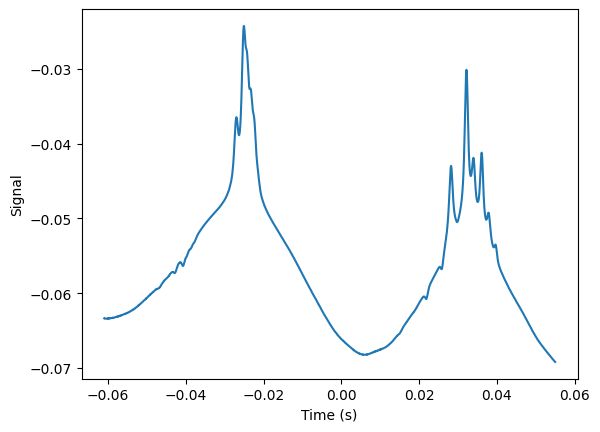

In [771]:
# Truncate data

weighted_mean_spectrum = weighted_mean_spectrum[800:3700]
err_mean_spectrum = err_mean_spectrum[800:3700]
mean_spectrum_time = mean_spectrum_time[800:3700]

plt.plot(mean_spectrum_time, weighted_mean_spectrum)
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.show()

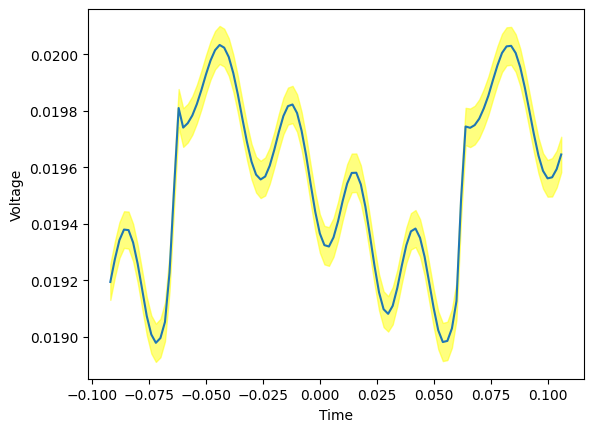

Minimum error: 6.261363185904883e-05
Maximum error: 6.881566557944651e-05
100
100


In [772]:
# TIME-AVERAGING THE CALIBRATION DATA

#work out averages by grouping

N_GROUPS = 100
group_step = N_POINTS//N_GROUPS # calculating group sizes
# 5 million data points and 5000 groups gives group step of 1000
# 100,000 data points and 5000 groups gives group step of 20
# 100,000 data points and 100 groups gives group step of 1000

if N_POINTS % N_GROUPS != 0:
    print("Warning: data points do not divide evenly into groups.")

mean_calibration_time = np.zeros(N_GROUPS)
weighted_mean_calibration = np.zeros(N_GROUPS)
err_mean_calibration= np.zeros(N_GROUPS)

# weighted mean calculations: page 66 hughes & hase
w = 1 / (std_calibration / np.sqrt(N_MEASUREMENTS - 1))**2
x = mean_calibration

if np.any(std_calibration == 0):
    raise ValueError("Standard deviation contains zero values, which would cause division by zero.")

for i in range(N_GROUPS):
    # start_idx = i * group_step
    # end_idx = min((i + 1) * group_step, N_POINTS)
    # mean_spectrum_time[i] = np.mean(spectrum_time[start_idx:end_idx]) # calculates average of spectrum_time for each group
    # weighted_mean_spectrum[i] = np.sum(x[start_idx:end_idx] * w[start_idx:end_idx]) / np.sum(w[start_idx:end_idx]) # weighted mean of the spectrum for each group

    mean_calibration_time[i] = np.mean(np.array(calibration_time[i*group_step : (i+1)*group_step]))
    weighted_mean_calibration[i] = np.sum(x[i*group_step:(i+1)*group_step]*w[i*group_step:(i+1)*group_step])/np.sum(w[i*group_step:(i+1)*group_step])
    err_mean_calibration[i] = np.sqrt(1/np.sum(w[i*group_step:(i+1)*group_step]))


plt.plot(mean_calibration_time, weighted_mean_calibration)
#plt.errorbar(mean_calibration_time, weighted_mean_calibration, yerr=abs(weighted_mean_calibration/np.sqrt(N_GROUPS-1)), capsize=3)
plt.fill_between(
    x=mean_calibration_time,
    y1=weighted_mean_calibration + err_mean_calibration,
    y2=weighted_mean_calibration - err_mean_calibration,
    alpha=0.5,
    color='yellow'
)

plt.xlabel('Time')
plt.ylabel('Voltage')
#plt.ylim(0, 0.03)
plt.show()


print("Minimum error:", np.min(err_mean_calibration))
print("Maximum error:", np.max(err_mean_calibration))
print(len(mean_calibration_time))
print(len(weighted_mean_calibration))

Text(0, 0.5, 'Voltage')

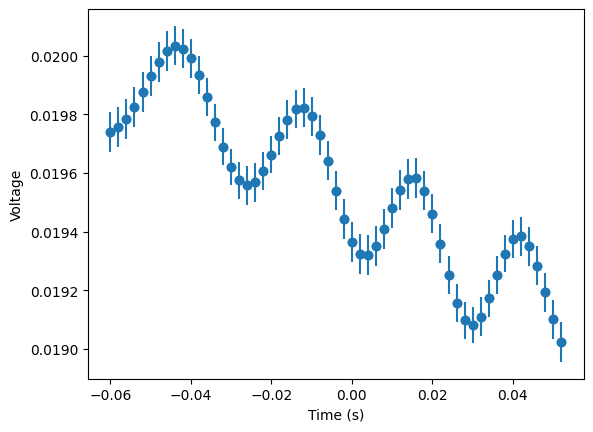

In [773]:
from scipy.signal import find_peaks
# non-uniform spacings between peaks, so relationship between time and frequency is non-linear. hence will use scipy.optimize to fit the data to a theoretical model

ct = mean_calibration_time[16:73]
cv = weighted_mean_calibration[16:73]
ce = err_mean_calibration[16:73]

plt.scatter(ct,cv)
plt.errorbar(ct, cv, yerr=ce, fmt='o')

plt.xlabel("Time (s)")
plt.ylabel("Voltage")

Calibration Fit Model:
chi^2_min = 4.038545903464109
reduced chi^2 = 0.07918717457772763
P(chi^2_min, DoF) = 1.0
A = -1.9043e-04 +/- 1.2475e-05
B2 = 2.7094e+02 +/- 7.5506e+01
B1 = 2.2226e+02 +/- 2.0375e+00
B0 = 1.0828e+00 +/- 1.0062e-01
C1 = -7.7438e-03 +/- 2.9079e-04
C0 = 1.9524e-02 +/- 8.9292e-06




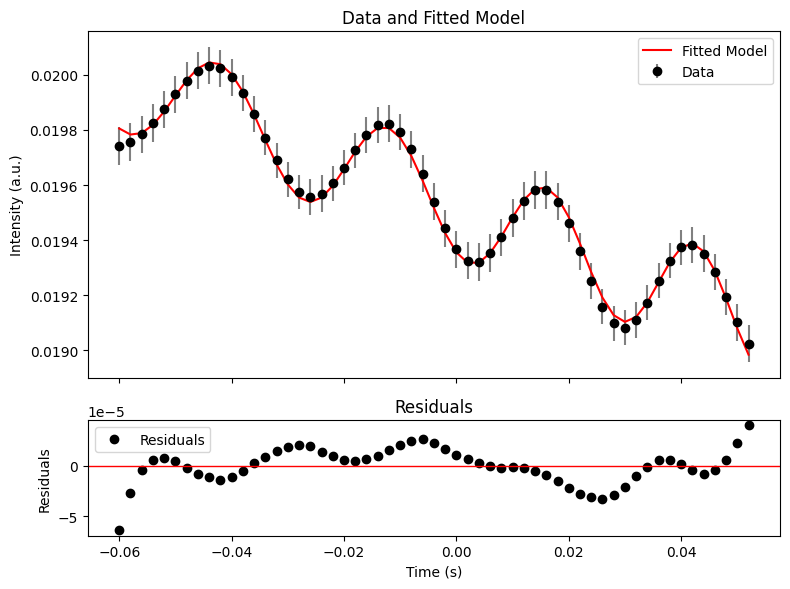

In [774]:
import numpy as np
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt

############################
# MODEL DEFINITION 
############################
# Model: A sinusoidal with a quadratic phase term controlling the fringe positions and a linear background drift
def calibration_fit(t, *params):
    A, B2, B1, B0, C1, C0 = params
    return (A)*np.sin(B2*t**2 + B1*t + B0) + (C1*t + C0)

############################
# CONSTRAINED FIT FUNCTION
############################
# If a parameter initial guess is zero, we hold it at zero.
def constrained_calibration_fit(t, *params):
    constrained_params = [params[i] if p0[i] != 0 else 0 for i in range(len(params))]
    return calibration_fit(t, *constrained_params)

############################
# DATA
############################
x_values = ct 
y_values = cv 
y_errors = ce 

############################
# INITIAL GUESSES
############################
p0 = [0.0004, 0.0001, 260, 1, -0.001, 0.02]
#p0 = [A, B2, B1, B0, C1, C0]

############################
# CURVE FITTING
############################
popt, pcov = scipy.optimize.curve_fit(
    f=constrained_calibration_fit,
    xdata=x_values,
    ydata=y_values,
    p0=p0,
    sigma=y_errors,
    absolute_sigma=True
)

############################
# RESIDUALS AND STATISTICS
############################
residuals = y_values - calibration_fit(x_values, *popt)
normalised_residuals = residuals / np.std(residuals)

def chi_squared(model_params, model, x_data, y_data, y_err):
    return np.sum(((y_data - model(x_data, *model_params))/y_err)**2)

def print_optimization_results(model_name, popt, cov, model, x_values, y_values, y_errors):
    parameter_names = ['A', 'B2', 'B1', 'B0', 'C1', 'C0']
    chi_squared_min = chi_squared(popt, model, x_values, y_values, y_errors)
    degrees_of_freedom = len(x_values) - len(popt)

    print(f'{model_name} Model:')
    print('chi^2_min = {}'.format(chi_squared_min))
    print('reduced chi^2 = {}'.format(chi_squared_min / degrees_of_freedom))
    print('P(chi^2_min, DoF) = {}'.format(scipy.stats.chi2.sf(chi_squared_min, degrees_of_freedom)))

    popt_errs = np.sqrt(np.diag(cov))
    for name, val, err in zip(parameter_names, popt, popt_errs):
        print(f'{name} = {val:.4e} +/- {err:.4e}')
    print('\n')

print_optimization_results('Calibration Fit', popt, pcov, calibration_fit, x_values, y_values, y_errors)

############################
# PLOTTING DATA, FIT, AND RESIDUALS
############################

# Compute fitted curve for plotting
fit_curve = calibration_fit(x_values, *popt)

fig, (ax_main, ax_res) = plt.subplots(2, 1, figsize=(8, 6), sharex=True,
                                      gridspec_kw={'height_ratios': [3, 1]})

# Main plot: data with errors and fitted model
ax_main.errorbar(x_values, y_values, yerr=y_errors, fmt='o', color='black', ecolor='gray', label='Data')
ax_main.plot(x_values, fit_curve, 'r-', label='Fitted Model')
ax_main.set_ylabel('Intensity (a.u.)')
ax_main.set_title('Data and Fitted Model')
ax_main.legend()

# Residuals plot
ax_res.plot(x_values, residuals, 'ko', label='Residuals')
ax_res.axhline(0, color='red', linewidth=1)
ax_res.set_ylabel('Residuals')
ax_res.set_xlabel('Time (s)')
ax_res.set_title('Residuals')
ax_res.legend()

plt.tight_layout()
plt.show()

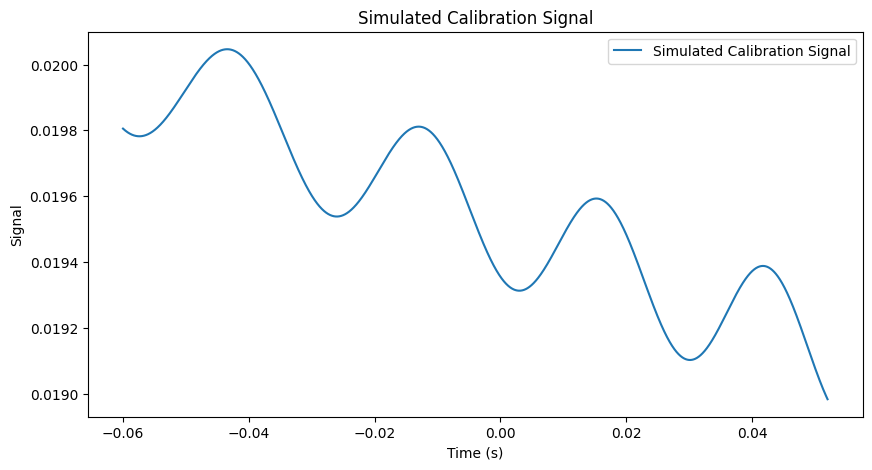

Detected peak times (s): [-0.04344409 -0.0129964   0.01525565  0.04173775]
Time intervals between fringes (s): [0.03044769 0.02825205 0.0264821 ]


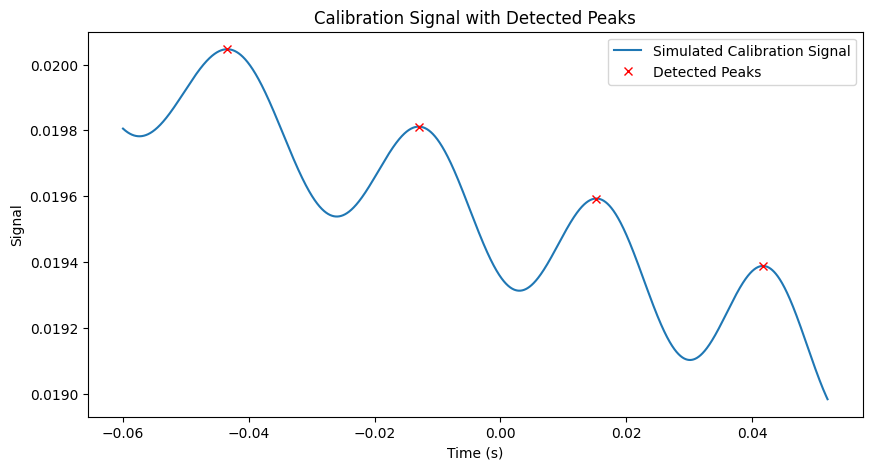

In [775]:
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

# Generate the calibration signal
calibration_times = np.linspace(min(ct), max(ct), 5000)  # Higher resolution
calibration_signal = calibration_fit(calibration_times, *popt)  # Simulate signal

# Visualize the simulated signal
plt.figure(figsize=(10, 5))
plt.plot(calibration_times, calibration_signal, label="Simulated Calibration Signal")
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.title("Simulated Calibration Signal")
plt.legend()
plt.show()

# Adjust prominence or other parameters for peak detection
calibration_peaks, _ = find_peaks(calibration_signal, prominence=-0.005)  # Relaxed prominence
if len(calibration_peaks) == 0:
    print("No peaks detected! Check prominence or signal resolution.")
else:
    # Extract times of detected peaks
    calibration_peak_times = calibration_times[calibration_peaks]

    # Print detected peaks
    print("Detected peak times (s):", calibration_peak_times)

    # Calculate time intervals between peaks
    time_intervals = np.diff(calibration_peak_times)
    print("Time intervals between fringes (s):", time_intervals)

    # Plot peaks on the signal
    plt.figure(figsize=(10, 5))
    plt.plot(calibration_times, calibration_signal, label="Simulated Calibration Signal")
    plt.plot(calibration_peak_times, calibration_signal[calibration_peaks], "rx", label="Detected Peaks")
    plt.xlabel("Time (s)")
    plt.ylabel("Signal")
    plt.title("Calibration Signal with Detected Peaks")
    plt.legend()
    plt.show()

270.94026009952614
222.2575236897494
1.0828456479822495
Experimental Sweep Rates at Peaks (Hz/s): [-6.51940452e+08 -1.42326661e+08  3.66874891e+08  8.75935090e+08]
Average Experimental Sweep Rate: 1.121357e+08 Hz/s


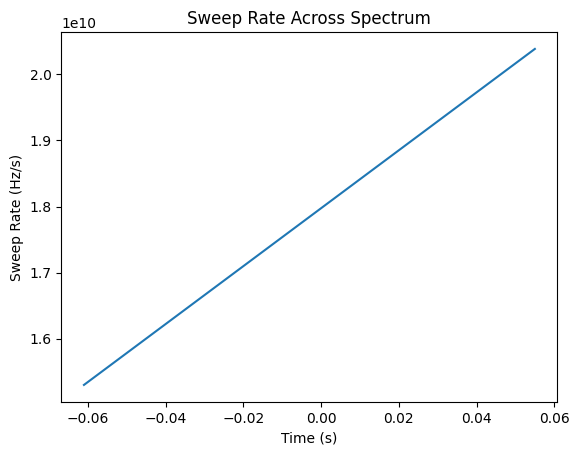

In [776]:
# From the above we can see that the B2 value of the model is not 0 otherwise the frequency spacing would be even and the time intervals would be the same. So we can calculate an experimental value for our sweep rate and compare it to the theoretical

path_diff = 0.62

from scipy.constants import c

def sweep_rate(t, B2, B1):
    return (B2*t**2 + B1*t + B0) * (c/(4*np.pi*0.295)) # converts it to Hz

# Extract phase coefficients from fitted parameters
B2 = popt[1]
B1 = popt[2]
B0 = popt[3]

print(B2)
print(B1)
print(B0)

# Calculate experimental sweep rates at detected peak times
experimental_sweep_rates = sweep_rate(calibration_peak_times, B2, B1)
print("Experimental Sweep Rates at Peaks (Hz/s):", experimental_sweep_rates)

# Average experimental sweep rate
average_experimental_sweep_rate = np.mean(experimental_sweep_rates)
print(f"Average Experimental Sweep Rate: {average_experimental_sweep_rate:.6e} Hz/s")

# Instantaneous sweep rate
sweep_rate = (2 * B2 * mean_spectrum_time + B1) * (c / (4 * np.pi * 0.295))

# Plot the sweep rate
plt.plot(mean_spectrum_time, sweep_rate)
plt.xlabel("Time (s)")
plt.ylabel("Sweep Rate (Hz/s)")
plt.title("Sweep Rate Across Spectrum")
plt.show()


In [777]:
# Interferometer path length difference
delta_L = 0.295

# Theoretical Hz/fringe
hz_per_fringe_theoretical = c / (2 * delta_L)
print(f"Theoretical Hz/Fringe: {hz_per_fringe_theoretical:.6e} Hz/fringe")

# Experimental average time interval from detected fringes
average_time_interval = np.mean(time_intervals)
std_time_interval = np.std(time_intervals)

# Theoretical sweep rate 
sweep_rate_theoretical = hz_per_fringe_theoretical / average_time_interval
print(f"Theoretical Sweep Rate: {sweep_rate_theoretical:.6e} Hz/s")

Theoretical Hz/Fringe: 5.081228e+08 Hz/fringe
Theoretical Sweep Rate: 1.789546e+10 Hz/s


In [778]:
# Compare sweep rates
difference = average_experimental_sweep_rate - sweep_rate_theoretical
percent_difference = (difference / sweep_rate_theoretical) * 100

print(f"Difference: {difference:.6e} Hz/s")
print(f"Percentage Difference: {percent_difference:.2f}%")

Difference: -1.778333e+10 Hz/s
Percentage Difference: -99.37%


In [779]:
# Convert spectrum time to frequency (ASSUMES ITS LINEAR)
spectrum_frequency_LINEAR = mean_spectrum_time * average_experimental_sweep_rate

# Using the fitted parameters from your calibration
spectrum_frequency = (2*B2*mean_spectrum_time + B1)* (c / (4 * np.pi * 0.295))  # Add B0 if there's an absolute offset

print("Spectrum Frequency (Hz):", spectrum_frequency)



Spectrum Frequency (Hz): [1.53017126e+10 1.53034655e+10 1.53052184e+10 ... 2.03798080e+10
 2.03815608e+10 2.03833137e+10]


In [780]:
print(spectrum_frequency_LINEAR)


[-6838148.15059963 -6833662.72192473 -6829177.29324983 ...
  6156138.72058131  6160624.14925621  6165109.57793111]


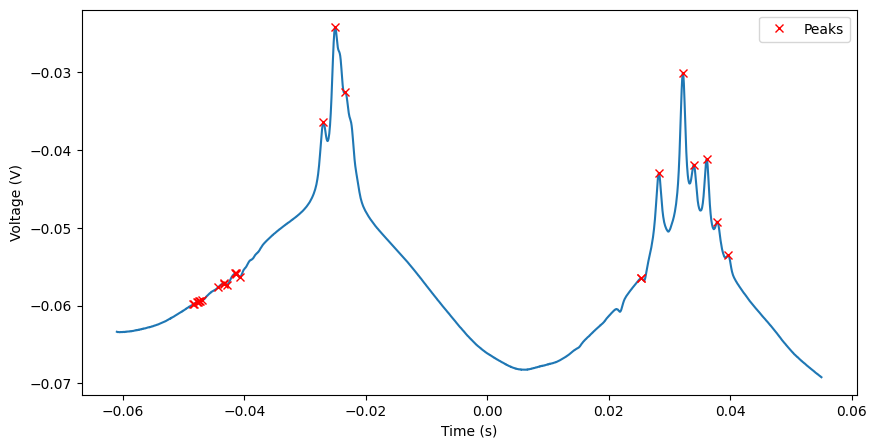

Spectrum Peaks:
Peak 1: Time = -0.048461000000000004
Peak 2: Time = -0.048301000000000004
Peak 3: Time = -0.047820999999999995
Peak 4: Time = -0.047581000000000005
Peak 5: Time = -0.047501
Peak 6: Time = -0.047301
Peak 7: Time = -0.046941
Peak 8: Time = -0.044341000000000005
Peak 9: Time = -0.043380999999999996
Peak 10: Time = -0.043301000000000006
Peak 11: Time = -0.042901
Peak 12: Time = -0.041540999999999995
Peak 13: Time = -0.041421
Peak 14: Time = -0.041301000000000004
Peak 15: Time = -0.040741000000000006
Peak 16: Time = -0.026981000000000005
Peak 17: Time = -0.025061000000000007
Peak 18: Time = -0.023421000000000004
Peak 19: Time = 0.025258999999999997
Peak 20: Time = 0.025338999999999993
Peak 21: Time = 0.028218999999999994
Peak 22: Time = 0.032179
Peak 23: Time = 0.033978999999999995
Peak 24: Time = 0.036099
Peak 25: Time = 0.03785899999999999
Peak 26: Time = 0.03965899999999999


In [781]:
# Prior to scaling time axis

from scipy.signal import find_peaks

# Identify peaks in the spectrum data
spectrum_peaks, _ = find_peaks(weighted_mean_spectrum, height=-0.06)  # Adjust height and distance as needed

# Extract peak times
spectrum_peak_times = mean_spectrum_time[spectrum_peaks]

# Plot spectrum with frequency on the x-axis
plt.figure(figsize=(10, 5))

plt.plot(mean_spectrum_time, weighted_mean_spectrum)
plt.plot(mean_spectrum_time[spectrum_peaks], weighted_mean_spectrum[spectrum_peaks], "rx", label="Peaks")  
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend()
plt.show()

print("Spectrum Peaks:")
for i, t in enumerate(mean_spectrum_time[spectrum_peaks]):
    print(f"Peak {i + 1}: Time = {t}")

In [783]:
# Choose a reference peak for zero detuning and apply
reference_peak_index = 20
reference_frequency = spectrum_frequency[spectrum_peaks[reference_peak_index]]

detuned_frequency = spectrum_frequency - reference_frequency

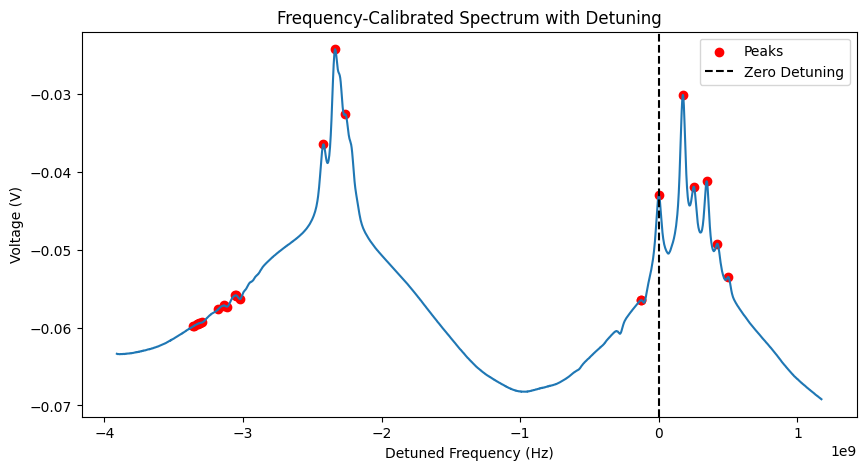

In [784]:
plt.figure(figsize=(10, 5))
# plt.plot(adjusted_frequency, weighted_mean_spectrum)
# plt.scatter(adjusted_frequency[spectrum_peaks], weighted_mean_spectrum[spectrum_peaks], color='red', label="Peaks")

plt.plot(detuned_frequency, weighted_mean_spectrum)
plt.scatter(detuned_frequency[spectrum_peaks], weighted_mean_spectrum[spectrum_peaks], color='red', label="Peaks")
plt.axvline(0, color='black', linestyle='--', label="Zero Detuning") 

# lit_lines = (np.array([-1.1647,-1.2853,-1.3487,-2.2909,-2.5578,-2.7148]))*10**(9)
# for lit_peak in lit_lines:
#     plt.axvline(lit_peak, color='blue', linestyle='--', label="Literature Peak")


plt.xlabel("Detuned Frequency (Hz)")
plt.ylabel("Voltage (V)")
plt.title("Frequency-Calibrated Spectrum with Detuning")
plt.legend()
#plt.xlim([-0.1e9, detuned_frequency[-1]])
plt.show()
# 87Rb F=2 transitions

In [785]:
# print("Spectrum Peaks (Detuned Frequencies):")
# for i, peak_index in enumerate(spectrum_peaks):
#     print(f"Peak {i + 1}: Frequency = {adjusted_frequency[peak_index] / 1e6} MHz, Voltage = {weighted_mean_spectrum[peak_index]:.2f}")
#     
print("Spectrum Peaks (Detuned Frequencies):")
for i, peak_index in enumerate(spectrum_peaks):
    print(f"Peak {i + 1}: Frequency = {detuned_frequency[peak_index] / 1e6} MHz, Voltage = {weighted_mean_spectrum[peak_index]:.2f}")

Spectrum Peaks (Detuned Frequencies):
Peak 1: Frequency = -3360.272255679565 MHz, Voltage = -0.06
Peak 2: Frequency = -3353.2607329760076 MHz, Voltage = -0.06
Peak 3: Frequency = -3332.2261648653393 MHz, Voltage = -0.06
Peak 4: Frequency = -3321.7088808100034 MHz, Voltage = -0.06
Peak 5: Frequency = -3318.2031194582232 MHz, Voltage = -0.06
Peak 6: Frequency = -3309.438716078779 MHz, Voltage = -0.06
Peak 7: Frequency = -3293.6627899957753 MHz, Voltage = -0.06
Peak 8: Frequency = -3179.725546062981 MHz, Voltage = -0.06
Peak 9: Frequency = -3137.6564098416384 MHz, Voltage = -0.06
Peak 10: Frequency = -3134.1506484898587 MHz, Voltage = -0.06
Peak 11: Frequency = -3116.6218417309683 MHz, Voltage = -0.06
Peak 12: Frequency = -3057.0238987507364 MHz, Voltage = -0.06
Peak 13: Frequency = -3051.7652567230684 MHz, Voltage = -0.06
Peak 14: Frequency = -3046.5066146954023 MHz, Voltage = -0.06
Peak 15: Frequency = -3021.966285232954 MHz, Voltage = -0.06
Peak 16: Frequency = -2418.9753327270737 MHz,

In [786]:
print("Spectrum Peaks (Detuned Frequencies in MHz):")
previous_frequency_mhz = None
for i, peak_index in enumerate(spectrum_peaks):
    current_frequency_mhz = detuned_frequency[peak_index] / 1e6
    print(f"Peak {i + 1}: Frequency = {current_frequency_mhz:.6f} MHz, Voltage = {weighted_mean_spectrum[peak_index]:.2f}")
    if previous_frequency_mhz is not None:
        diff_mhz = current_frequency_mhz - previous_frequency_mhz
        print(f"   Difference from previous peak: {diff_mhz:.6f} MHz")
    previous_frequency_mhz = current_frequency_mhz



Spectrum Peaks (Detuned Frequencies in MHz):
Peak 1: Frequency = -3360.272256 MHz, Voltage = -0.06
Peak 2: Frequency = -3353.260733 MHz, Voltage = -0.06
   Difference from previous peak: 7.011523 MHz
Peak 3: Frequency = -3332.226165 MHz, Voltage = -0.06
   Difference from previous peak: 21.034568 MHz
Peak 4: Frequency = -3321.708881 MHz, Voltage = -0.06
   Difference from previous peak: 10.517284 MHz
Peak 5: Frequency = -3318.203119 MHz, Voltage = -0.06
   Difference from previous peak: 3.505761 MHz
Peak 6: Frequency = -3309.438716 MHz, Voltage = -0.06
   Difference from previous peak: 8.764403 MHz
Peak 7: Frequency = -3293.662790 MHz, Voltage = -0.06
   Difference from previous peak: 15.775926 MHz
Peak 8: Frequency = -3179.725546 MHz, Voltage = -0.06
   Difference from previous peak: 113.937244 MHz
Peak 9: Frequency = -3137.656410 MHz, Voltage = -0.06
   Difference from previous peak: 42.069136 MHz
Peak 10: Frequency = -3134.150648 MHz, Voltage = -0.06
   Difference from previous peak